# Lyrics analysis

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from ast import literal_eval
from itertools import chain
from collections import Counter
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
stop_words = set(nltk.corpus.stopwords.words('english'))
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Load data

In [2]:
# Load data with keeping structures inside data frame
songs = pd.read_csv('lyrics_processed_data.csv', converters = {'Tokenized Lyrics': literal_eval, 'Lemmatized Words': literal_eval}) 
display(songs)

,Position,Artist,Song Title,Year,JSON file,Split Names,Song Language,Lyrics,Tokenized Lyrics,Lemmatized Words,Corpus
0,2,Nat King Cole,Mona Lisa,1950,1.json,Nat King Cole,en,"mona lisa, mona lisa, men have named you you'r...","[mona, lisa, mona, lisa, men, have, named, you...","[mona, lisa, mona, lisa, men, have, name, you,...",mona lisa mona lisa men name like lady mystic ...
1,4,Gary and Bing Crosby,Sam's Song,1950,3.json,Gary,en,"ah, here's a happy tune, you'll love to croon ...","[ah, here, s, a, happy, tune, you, ll, love, t...","[ah, here, s, a, happy, tune, you, ll, love, t...",ah happy tune love croon call sam song catchy ...
2,5,Gary and Bing Crosby,Simple Melody,1950,4.json,Gary,en,won't you play some simple melody like my moth...,"[won, t, you, play, some, simple, melody, like...","[win, t, you, play, some, simple, melody, like...",win play simple melody like mother sing one go...
3,6,Teresa Brewer,"Music, Music, Music",1950,5.json,Teresa Brewer,en,put another nickel in in the nickelodeon all i...,"[put, another, nickel, in, in, the, nickelodeo...","[put, another, nickel, in, in, the, nickelodeo...",put another nickel nickelodeon want music musi...
4,8,Red Foley,Chattanoogie Shoe Shine Boy,1950,7.json,Red Foley,en,have you ever passed the corner of forth and g...,"[have, you, ever, passed, the, corner, of, for...","[have, you, ever, pass, the, corner, of, forth...",ever pass corner forth grand little ball rhyth...
...,...,...,...,...,...,...,...,...,...,...,...
6283,95,Cole Swindell,Single Saturday Night,2021,6774.json,Cole Swindell,en,i was out taking shots throwing down at the sp...,"[i, was, out, taking, shots, throwing, down, a...","[i, be, out, take, shots, throw, down, at, the...",take shots throw spot three sheet guy every si...
6284,96,Lainey Wilson,Things A Man Oughta Know,2021,6775.json,Lainey Wilson,en,i can hook a trailer on a two-inch hitch i can...,"[i, can, hook, a, trailer, on, a, two, inch, h...","[i, can, hook, a, trailer, on, a, two, inch, h...",hook trailer two inch hitch shoot shotgun catc...
6285,97,BRS Kash,Throat Baby (Go Baby),2021,6776.json,BRS Kash,en,"(what's happenin', chi chi?) sexy lil' bitch...","[what, s, happenin, chi, chi, sexy, lil, bitch...","[what, s, happenin, chi, chi, sexy, lil, bitch...",happenin chi chi sexy lil bitch sexy lil ho lo...
6286,98,Rod Wave,Tombstone,2021,6777.json,Rod Wave,en,"damn, this motherfucker too crazy, saucii let ...","[damn, this, motherfucker, too, crazy, saucii,...","[damn, this, motherfucker, too, crazy, saucii,...",damn motherfucker crazy saucii let shit ride e...


### Songs and words plots

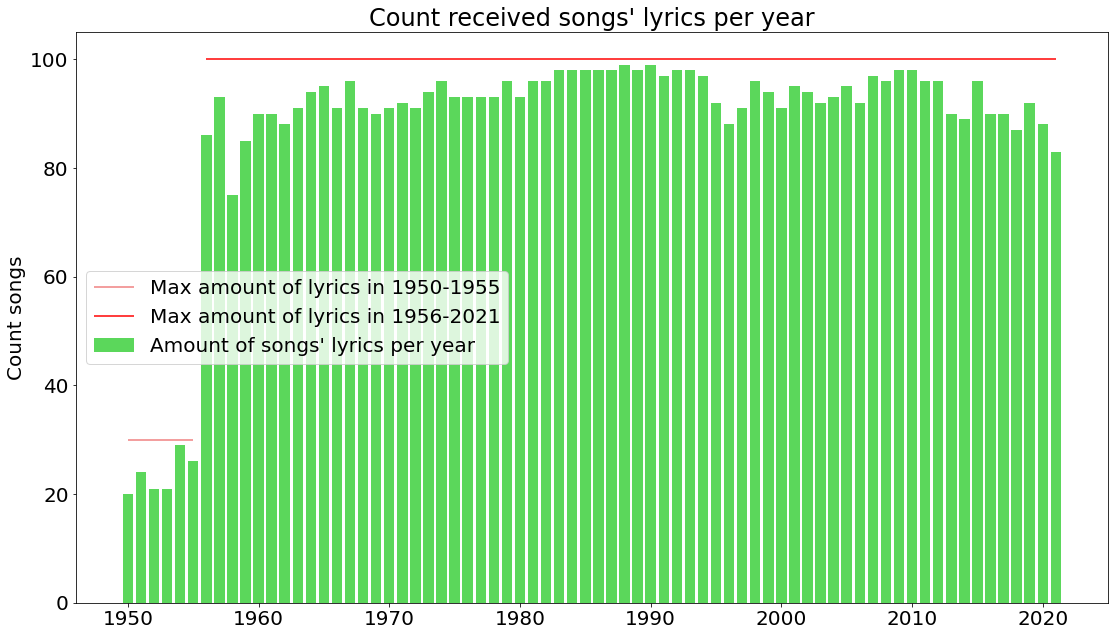

In [3]:
# Count received songs' lyrics per year
grouped_by_year = songs.groupby('Year').size()
plt.figure(figsize = (18.5, 10.5))
plt.bar(grouped_by_year.index, grouped_by_year, color = 'limegreen', alpha = 0.8)
plt.hlines(y = 30, xmin = 1950, xmax = 1955, colors = 'lightcoral')
plt.hlines(y = 100, xmin = 1956, xmax = 2021, colors='r')
plt.ylabel('Count songs')
plt.legend(['Max amount of lyrics in 1950-1955', 'Max amount of lyrics in 1956-2021', 'Amount of songs\' lyrics per year'], loc = 6)
plt.title('Count received songs\' lyrics per year')
plt.savefig('pobrane_piosenki.pdf')

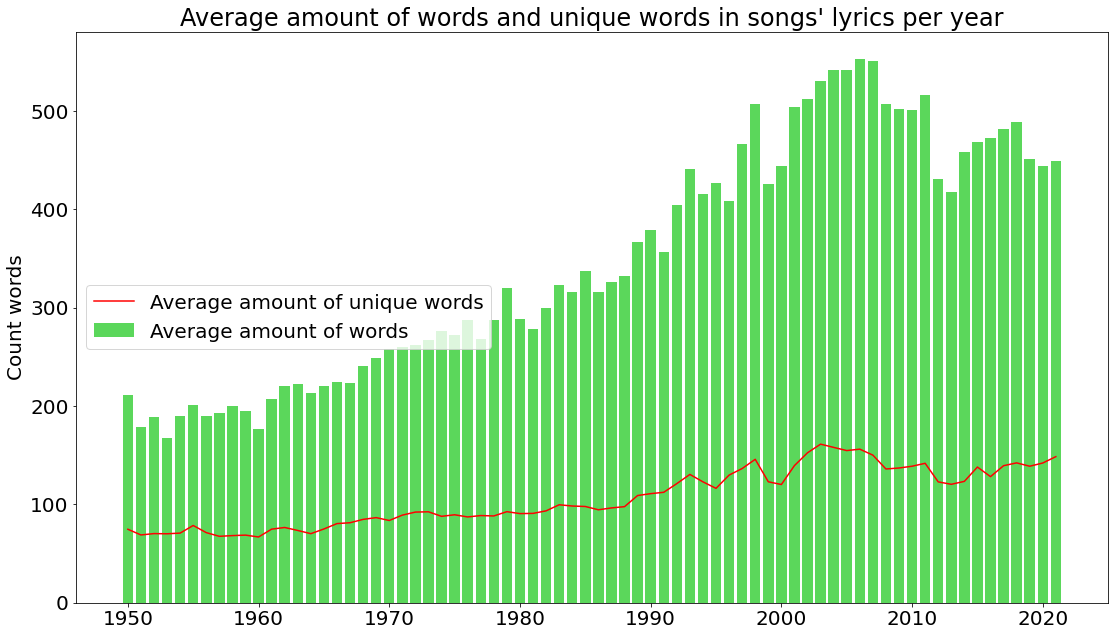

In [4]:
# Average number of words and unique in lyrics
unique = [len(set(i)) for i in songs['Tokenized Lyrics']]
songs['Tokenized Lyrics length'] = songs['Tokenized Lyrics'].str.len()
songs['Tokenized Unique Lyrics length'] = unique
grouped_mean = songs.groupby('Year')['Tokenized Lyrics length'].mean()
grouped_unique_mean = songs.groupby('Year')['Tokenized Unique Lyrics length'].mean()

plt.figure(figsize = (18.5, 10.5))
plt.bar(grouped_mean.index, grouped_mean, color = 'limegreen', alpha = 0.8)
plt.plot(grouped_unique_mean, color = 'r')
plt.ylabel('Count words')
plt.legend(['Average amount of unique words', 'Average amount of words'], loc = 6)
plt.title('Average amount of words and unique words in songs\' lyrics per year')
plt.savefig('slowa.pdf', bbox_inches = 'tight')

### Word cloud

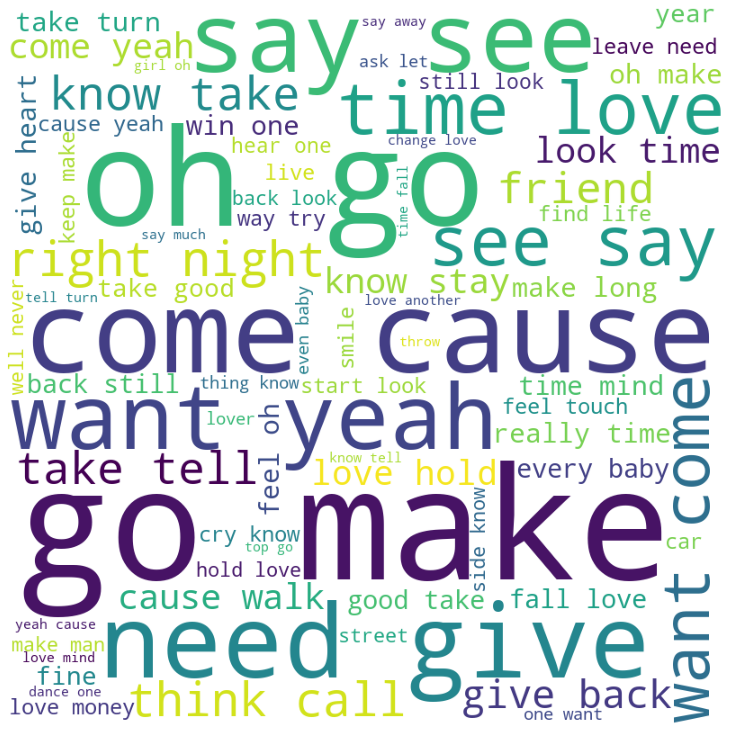

In [5]:
set_lyrics = [set(i) for i in songs['Corpus'].str.split()]
set_lyrics = list(chain(*set_lyrics))
join_lyrics = (" ").join(set_lyrics)

wordcloud = WordCloud(width = 800, height = 800, background_color = 'white', stopwords = STOPWORDS, min_font_size = 15).generate(join_lyrics)
plt.figure(figsize = (18.5, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('wordcloud.pdf', dpi = 100, bbox_inches = 'tight')
plt.show()

### Most popular words

In [6]:
# Three most popular words each year
songs_by_year = pd.DataFrame({'Year':list(range(1950, 2022))})
lyrics_per_year = []

# Function for converting list of lists to list of sets
def lists_to_sets(l):
    return [{i for i in row} for row in l]

# Combination of lyrics per year
years = songs['Year'].unique().tolist()
for i in years:
    song_lyrics = songs['Corpus'].str.split()[songs['Year'] == i].to_list()
    set_song_lyrics = lists_to_sets(song_lyrics)
    flat_song_lyrics = [item for i in set_song_lyrics for item in i]
    lyrics_per_year.append(flat_song_lyrics)
    
# Set for every song in particular year
songs_by_year['Combined Lyrics'] = lyrics_per_year


# Function for getting first values from tuple of most popular words
def first_from_list_of_tuples(lst):
    return [i[0] for i in lst]

lst_of_top3_words = [] 

# Create list of top 3 popular words
for i in songs_by_year['Combined Lyrics']:
    frq = FreqDist(i)
    top3_words = first_from_list_of_tuples(frq.most_common(3))
    lst_of_top3_words.append(top3_words)

# Set for every song in particular year
songs_by_year['Most Popular Words'] = lst_of_top3_words

display(songs_by_year)

,Year,Combined Lyrics,Most Popular Words
0,1950,"[lisa, cold, many, cause, way, bring, men, mon...","[love, see, know]"
1,1951,"[may, try, begin, say, go, mean, word, know, t...","[love, heart, know]"
2,1952,"[win, please, way, precious, day, wheel, someh...","[know, love, kiss]"
3,1953,"[cloud, win, spell, may, please, break, like, ...","[love, come, go]"
4,1954,"[forever, cross, champagne, dot, nice, cause, ...","[love, heart, know]"
...,...,...,...
67,2017,"[dance, one, find, begin, hand, radio, play, s...","[get, like, know]"
68,2018,"[one, sometimes, struggle, dog, cuddle, see, g...","[like, know, yeah]"
69,2019,"[spend, cross, tractor, yeah, old, ride, wish,...","[get, yeah, know]"
70,2020,"[one, run, city, cold, blind, yeah, cause, ooh...","[get, know, like]"


In [7]:
# 3 the most popular words of 1950 - 2021
most_popular_words_list = songs_by_year['Most Popular Words'].tolist()
most_popular_words = first_from_list_of_tuples(Counter(chain.from_iterable(most_popular_words_list)).most_common(3))
most_popular_words

['know', 'love', 'get']

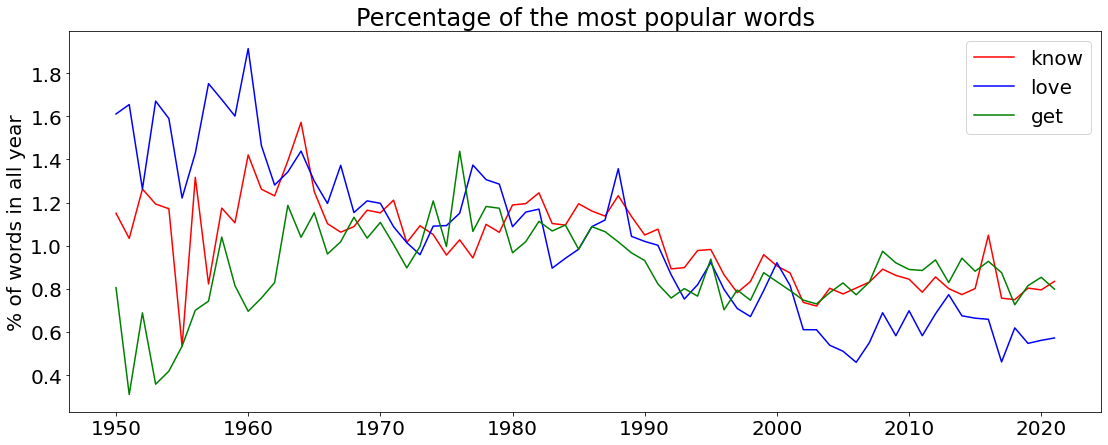

In [8]:
# Popular words plot
def count_perc_most_popular_word(list_of_words, word):
    occurence = list_of_words.count(word)
    return occurence / len(list_of_words) * 100

first_most_popular_word = [count_perc_most_popular_word(i, most_popular_words[0]) for i in songs_by_year['Combined Lyrics']]
second_most_popular_word = [count_perc_most_popular_word(i, most_popular_words[1]) for i in songs_by_year['Combined Lyrics']]
third_most_popular_word = [count_perc_most_popular_word(i, most_popular_words[2]) for i in songs_by_year['Combined Lyrics']]

plt.figure(figsize = (18.5, 7))
plt.plot(songs_by_year['Year'], first_most_popular_word, color = 'red', label = most_popular_words[0])
plt.plot(songs_by_year['Year'], second_most_popular_word, color = 'blue', label = most_popular_words[1])
plt.plot(songs_by_year['Year'], third_most_popular_word, color = 'green', label = most_popular_words[2])
plt.ylabel('% of words in all year')
plt.legend(most_popular_words)
plt.title('Percentage of the most popular words')
plt.savefig('popularne_slowa.pdf', bbox_inches = 'tight')

### Bad words classifier

In [9]:
# List of bad words
bad_words_df = pd.read_csv('https://www.cs.cmu.edu/~biglou/resources/bad-words.txt', sep = "\n", header = None, names = ['Word'])
bad_words = bad_words_df['Word'].tolist()

In [10]:
# Measure level of vulgarity for each song in years 1950 - 2021 (in %)
# Calculate % of bad words
def level_of_vulgarity(lemm_list):
    counter = 0
    for i in lemm_list:
        if i in bad_words:
            counter += 1
    level = counter / len(lemm_list) * 100
    return level

list_of_levels = []
for i in songs['Corpus'].str.split():
    list_of_levels.append(level_of_vulgarity(i))
    
songs['Vulgarity Level'] = list_of_levels
songs['Vulgarity Level'] = songs['Vulgarity Level'].round(2)

display(songs[['Position', 'Artist', 'Song Title', 'Year', 'Vulgarity Level']])

,Position,Artist,Song Title,Year,Vulgarity Level
0,2,Nat King Cole,Mona Lisa,1950,2.90
1,4,Gary and Bing Crosby,Sam's Song,1950,0.00
2,5,Gary and Bing Crosby,Simple Melody,1950,3.09
3,6,Teresa Brewer,"Music, Music, Music",1950,0.00
4,8,Red Foley,Chattanoogie Shoe Shine Boy,1950,0.00
...,...,...,...,...,...
6283,95,Cole Swindell,Single Saturday Night,2021,2.62
6284,96,Lainey Wilson,Things A Man Oughta Know,2021,3.20
6285,97,BRS Kash,Throat Baby (Go Baby),2021,13.42
6286,98,Rod Wave,Tombstone,2021,7.66


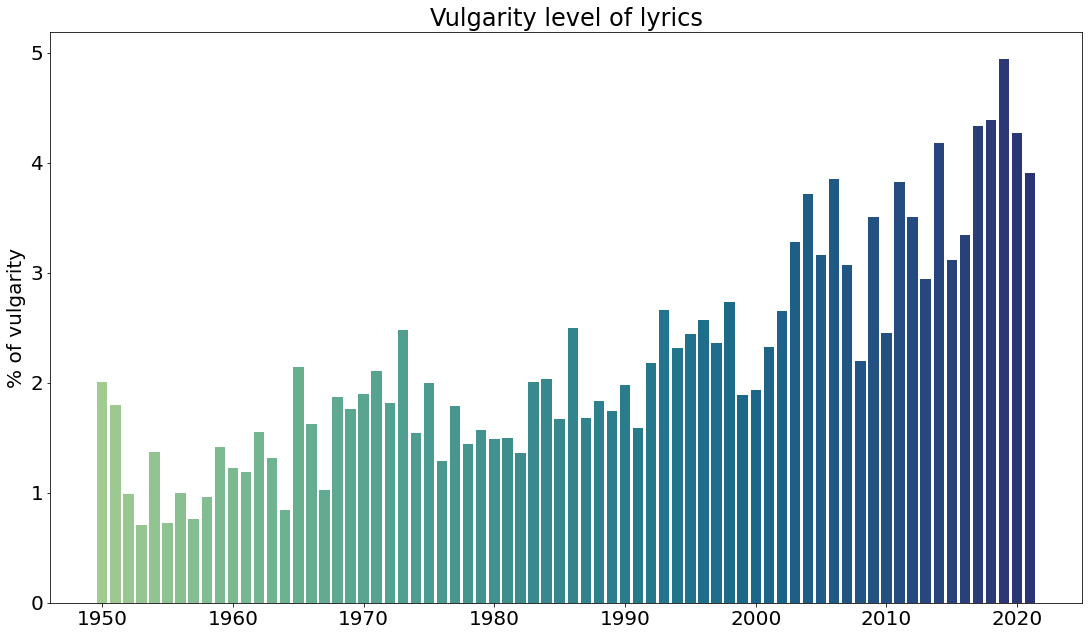

In [11]:
# Vulgarity level each year plot
grouped_vulgsrity = songs.groupby('Year')['Vulgarity Level'].aggregate('mean').tolist()
songs_by_year['Mean Vulgarity'] = grouped_vulgsrity
plt.figure(figsize = (18.5, 10.5))
plt.bar(songs_by_year['Year'], grouped_vulgsrity, color = sns.color_palette('crest', len(songs_by_year)))
plt.ylabel('% of vulgarity')
plt.title('Vulgarity level of lyrics')
plt.savefig('wulgarnosc.pdf', bbox_inches = 'tight')
plt.show()
plt.close()

In [12]:
# 3 most popular words classified as bad words each year
lst_of_top3_bad_words = []

for i in songs_by_year['Combined Lyrics']:
    i = pd.Series(i)
    bad_words_series = pd.Series(bad_words)
    bad_lyrics = i[i.isin(bad_words_series)]
    frq = FreqDist(bad_lyrics)
    top3_bad_words = first_from_list_of_tuples(frq.most_common(3))
    lst_of_top3_bad_words.append(top3_bad_words)
    
songs_by_year['Most Popular Bad Words'] = lst_of_top3_bad_words

display(songs_by_year)

,Year,Combined Lyrics,Most Popular Words,Mean Vulgarity,Most Popular Bad Words
0,1950,"[lisa, cold, many, cause, way, bring, men, mon...","[love, see, know]",2.004500,"[fire, die, demon]"
1,1951,"[may, try, begin, say, go, mean, word, know, t...","[love, heart, know]",1.802083,"[burn, desire, die]"
2,1952,"[win, please, way, precious, day, wheel, someh...","[know, love, kiss]",0.988095,"[fire, slave, burn]"
3,1953,"[cloud, win, spell, may, please, break, like, ...","[love, come, go]",0.702857,"[die, burn, jesus]"
4,1954,"[forever, cross, champagne, dot, nice, cause, ...","[love, heart, know]",1.373793,"[boom, fear, die]"
...,...,...,...,...,...
67,2017,"[dance, one, find, begin, hand, radio, play, s...","[get, like, know]",4.331778,"[bitch, fuck, shit]"
68,2018,"[one, sometimes, struggle, dog, cuddle, see, g...","[like, know, yeah]",4.384138,"[shit, fuck, bitch]"
69,2019,"[spend, cross, tractor, yeah, old, ride, wish,...","[get, yeah, know]",4.940761,"[shit, fuck, bitch]"
70,2020,"[one, run, city, cold, blind, yeah, cause, ooh...","[get, know, like]",4.273977,"[bitch, fuck, shit]"


In [13]:
# 3 the most popular bad words of 1950 - 2021
most_popular_bad_words_list = songs_by_year['Most Popular Bad Words'].tolist()
most_popular_bad_words = first_from_list_of_tuples(Counter(chain.from_iterable(most_popular_bad_words_list)).most_common(3))
most_popular_bad_words

['die', 'shit', 'burn']

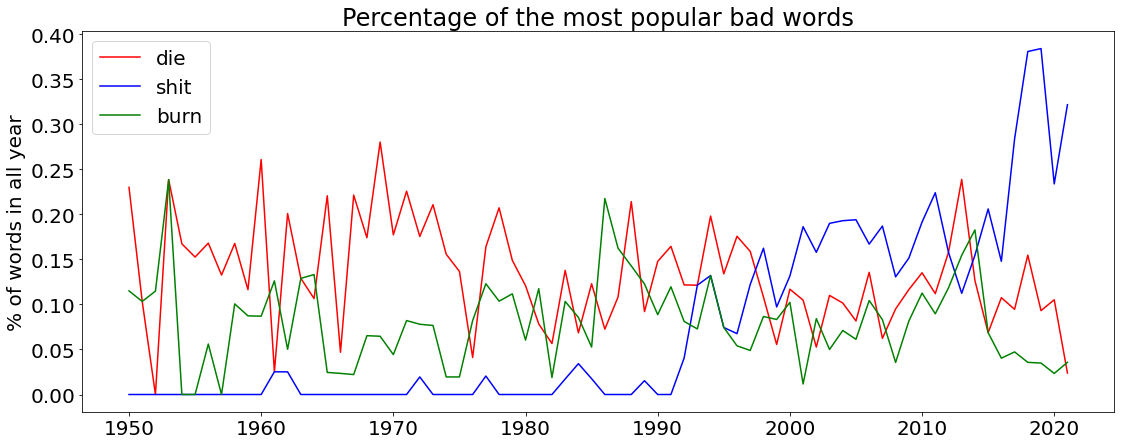

In [14]:
# Popular bad words occurence plot
first_most_popular_bad_word_occurence = [count_perc_most_popular_word(i, most_popular_bad_words[0]) for i in songs_by_year['Combined Lyrics']]
second_most_popular_bad_word_occurence = [count_perc_most_popular_word(i, most_popular_bad_words[1]) for i in songs_by_year['Combined Lyrics']]
third_most_popular_bad_word_occurence = [count_perc_most_popular_word(i, most_popular_bad_words[2]) for i in songs_by_year['Combined Lyrics']]

plt.figure(figsize = (18.5, 7))
plt.plot(songs_by_year['Year'], first_most_popular_bad_word_occurence, color = 'red', label = most_popular_words[0])
plt.plot(songs_by_year['Year'], second_most_popular_bad_word_occurence, color = 'blue', label = most_popular_words[1])
plt.plot(songs_by_year['Year'], third_most_popular_bad_word_occurence, color = 'green', label = most_popular_words[2])
plt.ylabel('% of words in all year')
plt.legend(most_popular_bad_words)
plt.title('Percentage of the most popular bad words')
plt.savefig('popularne_zle_slowa.pdf', bbox_inches = 'tight')
plt.show()
plt.close()

### Sentiment analysis

In [15]:
sentiment = SentimentIntensityAnalyzer()
negative = []
neutral = []
positive = []
compound = []
rate = []
for i in songs['Corpus']:
    sent = sentiment.polarity_scores(i)
    negative.append(sent['neg'])
    neutral.append(sent['neu'])
    positive.append(sent['pos'])
    compound.append(sent['compound'])
    if sent['compound'] > 0:
        rate.append('Positive')
    elif sent['compound'] < 0:
        rate.append('Negative')
    else:
        rate.append('Neutral')
songs['Negative'] = negative
songs['Neutral'] = neutral
songs['Positive'] = positive
songs['Compound'] = compound
songs['Rate'] = rate

display(songs[['Position', 'Artist', 'Song Title', 'Year', 'Negative', 'Neutral', 'Positive', 'Compound', 'Rate']])

,Position,Artist,Song Title,Year,Negative,Neutral,Positive,Compound,Rate
0,2,Nat King Cole,Mona Lisa,1950,0.190,0.414,0.395,0.9712,Positive
1,4,Gary and Bing Crosby,Sam's Song,1950,0.077,0.653,0.270,0.9888,Positive
2,5,Gary and Bing Crosby,Simple Melody,1950,0.085,0.419,0.495,0.9961,Positive
3,6,Teresa Brewer,"Music, Music, Music",1950,0.000,0.743,0.257,0.9840,Positive
4,8,Red Foley,Chattanoogie Shoe Shine Boy,1950,0.016,0.674,0.309,0.9948,Positive
...,...,...,...,...,...,...,...,...,...
6283,95,Cole Swindell,Single Saturday Night,2021,0.087,0.735,0.178,0.9716,Positive
6284,96,Lainey Wilson,Things A Man Oughta Know,2021,0.104,0.573,0.323,0.9905,Positive
6285,97,BRS Kash,Throat Baby (Go Baby),2021,0.135,0.563,0.301,0.9979,Positive
6286,98,Rod Wave,Tombstone,2021,0.223,0.432,0.344,0.9794,Positive


In [16]:
# Mean sentiment per year
neg = songs.groupby('Year')['Negative'].aggregate('mean').tolist()
neu = songs.groupby('Year')['Neutral'].aggregate('mean').tolist()
pos = songs.groupby('Year')['Positive'].aggregate('mean').tolist()
comp = songs.groupby('Year')['Compound'].aggregate('mean').tolist()
songs_by_year['Negative'] = neg
songs_by_year['Neutral'] = neu
songs_by_year['Positive'] = pos
songs_by_year['Compound'] = comp
display(songs_by_year)

,Year,Combined Lyrics,Most Popular Words,Mean Vulgarity,Most Popular Bad Words,Negative,Neutral,Positive,Compound
0,1950,"[lisa, cold, many, cause, way, bring, men, mon...","[love, see, know]",2.004500,"[fire, die, demon]",0.072200,0.507350,0.420250,0.983420
1,1951,"[may, try, begin, say, go, mean, word, know, t...","[love, heart, know]",1.802083,"[burn, desire, die]",0.090833,0.555042,0.354208,0.780058
2,1952,"[win, please, way, precious, day, wheel, someh...","[know, love, kiss]",0.988095,"[fire, slave, burn]",0.105857,0.580048,0.313952,0.710695
3,1953,"[cloud, win, spell, may, please, break, like, ...","[love, come, go]",0.702857,"[die, burn, jesus]",0.100333,0.490476,0.409286,0.844271
4,1954,"[forever, cross, champagne, dot, nice, cause, ...","[love, heart, know]",1.373793,"[boom, fear, die]",0.072310,0.529379,0.398207,0.949245
...,...,...,...,...,...,...,...,...,...
67,2017,"[dance, one, find, begin, hand, radio, play, s...","[get, like, know]",4.331778,"[bitch, fuck, shit]",0.151967,0.592789,0.255222,0.364696
68,2018,"[one, sometimes, struggle, dog, cuddle, see, g...","[like, know, yeah]",4.384138,"[shit, fuck, bitch]",0.151425,0.585322,0.263287,0.423338
69,2019,"[spend, cross, tractor, yeah, old, ride, wish,...","[get, yeah, know]",4.940761,"[shit, fuck, bitch]",0.167315,0.593804,0.238957,0.320709
70,2020,"[one, run, city, cold, blind, yeah, cause, ooh...","[get, know, like]",4.273977,"[bitch, fuck, shit]",0.151864,0.600398,0.247716,0.365860


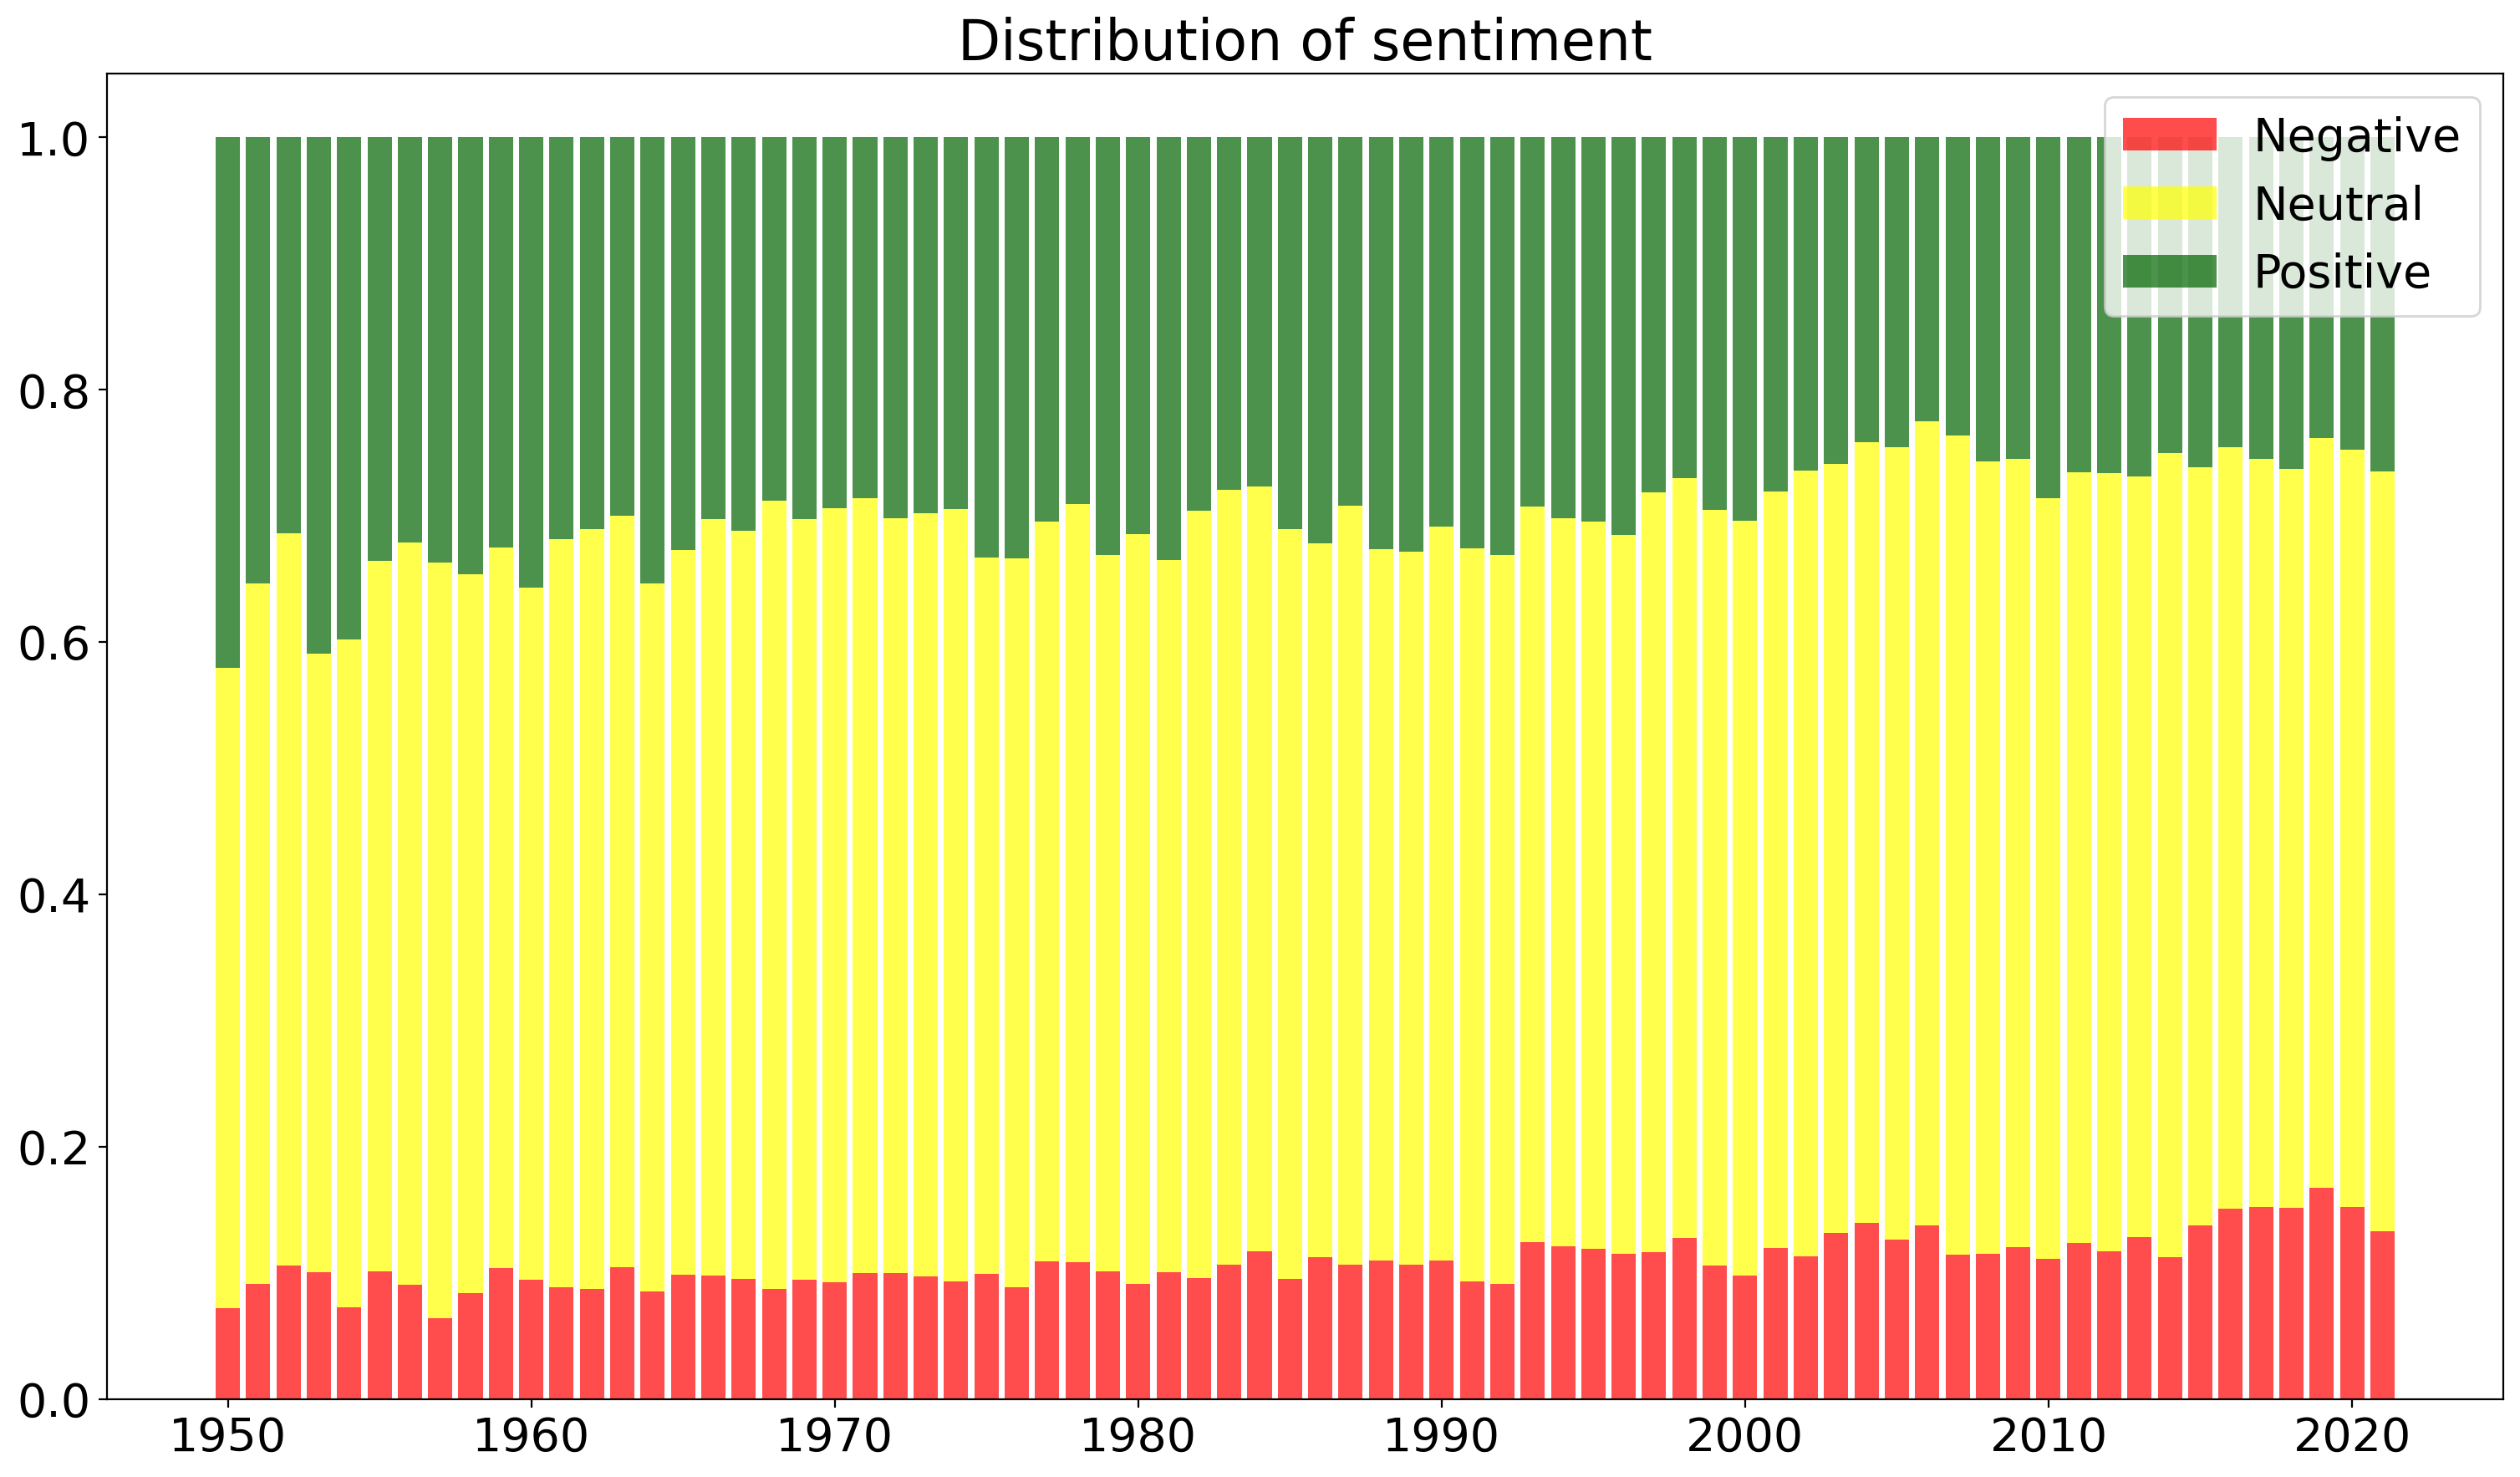

In [17]:
plt.figure(figsize = (18.5, 10.5), dpi=200)
plt.bar(songs_by_year['Year'], songs_by_year['Negative'], color = 'red', label = 'Negative', alpha = 0.7)
plt.bar(songs_by_year['Year'], songs_by_year['Neutral'], color = 'yellow', bottom = songs_by_year['Negative'].values, label = 'Neutral', alpha = 0.7)
plt.bar(songs_by_year['Year'], songs_by_year['Positive'], color = 'darkgreen', bottom = list(np.add(songs_by_year['Negative'].values, songs_by_year['Neutral'].values)), label = "Positive", alpha = 0.7)
plt.legend()
plt.title('Distribution of sentiment')
plt.savefig('wydzwiek.pdf')
plt.show()
plt.close()

### The most positive and negative songs

In [18]:
# The most positive songs
display(songs[['Position', 'Artist', 'Song Title', 'Year', 'Negative', 'Neutral', 'Positive', 'Compound', 'Rate']].sort_values(['Positive', 'Neutral', 'Negative'], ascending = False).head(5))

,Position,Artist,Song Title,Year,Negative,Neutral,Positive,Compound,Rate
851,14,Beatles,Love Me Do,1964,0.000,0.122,0.878,0.9992,Positive
1965,15,Diana Ross,Love Hangover,1976,0.007,0.136,0.857,1.0000,Positive
445,59,Frankie Avalon,Just Ask Your Heart,1959,0.000,0.157,0.843,0.9992,Positive
615,52,Paris Sisters,I Love How You Love Me,1961,0.047,0.122,0.831,0.9994,Positive
503,24,Frankie Avalon,Why,1960,0.042,0.151,0.807,0.9991,Positive


In [19]:
# The most negative songs
display(songs[['Position', 'Artist', 'Song Title', 'Year', 'Negative', 'Neutral', 'Positive', 'Compound', 'Rate']].sort_values(['Negative', 'Neutral', 'Positive'], ascending = False).head(5))

,Position,Artist,Song Title,Year,Negative,Neutral,Positive,Compound,Rate
5913,75,Jon Bellion,All Time Low,2017,0.810,0.134,0.056,-0.9998,Negative
4122,66,Ace Of Base,Cruel Summer,1998,0.706,0.246,0.048,-0.9993,Negative
2781,73,Bananarama,Cruel Summer,1984,0.705,0.239,0.056,-0.9991,Negative
1975,26,K.C. and The Sunshine Band,"(Shake, Shake, Shake) Shake Your Booty",1976,0.693,0.214,0.093,-0.9976,Negative
5844,97,Future,Wicked,2016,0.628,0.352,0.020,-0.9998,Negative


### Statistics for the most popular artists

In [20]:
# The most popular artists
most_popular_artists = songs['Artist'].value_counts().head(5).index.tolist()
most_popular_artists_songs = songs.query('Artist in @most_popular_artists')

In [21]:
grouped_by_artist = most_popular_artists_songs.groupby('Artist')[['Compound', 'Vulgarity Level']].aggregate('mean')
display(grouped_by_artist)

,Compound,Vulgarity Level
Artist,,
Beatles,0.791842,1.381923
Elton John,0.510108,2.418750
Elvis Presley,0.624847,2.425937
Madonna,0.858289,0.990286
Mariah Carey,0.645137,1.475185


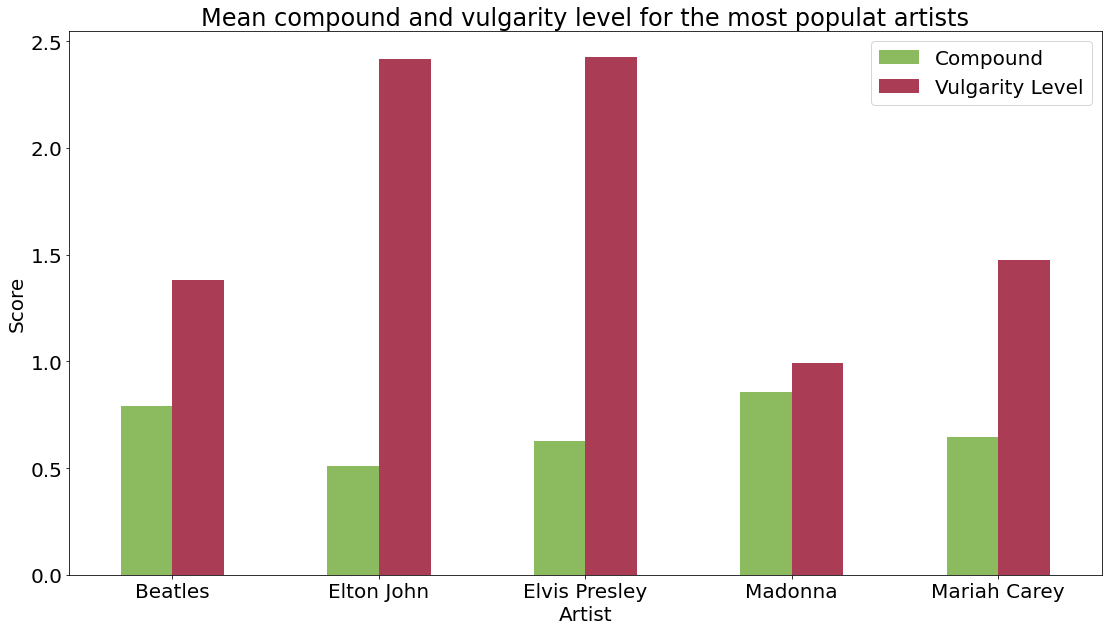

In [22]:
# Plot for mean compound and vulgarity level for the most popular artists
colors = ['#8cbB5f', '#ab3c55']
plot_art = grouped_by_artist.plot(kind = 'bar', color = colors, figsize = (18.5, 10), rot = 0, ylabel= 'Score', title = 'Mean compound and vulgarity level for the most populat artists')
plt.savefig('artysci.pdf', bbox_inches = 'tight')
plt.show()
plt.close()

### Topic identification

In [23]:
vectorize = TfidfVectorizer(stop_words = stop_words, max_features = 4000)
vectorized_text = vectorize.fit_transform(songs['Corpus'])
lda_model = LatentDirichletAllocation(n_components = 5, learning_method = 'online', random_state = 4, max_iter = 1)
lda_top = lda_model.fit_transform(vectorized_text)
vocab = vectorize.get_feature_names()

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x: x[1], reverse = True)[:20]
    print("Topic " + str(i) + ": ")
    for t in sorted_words:
        print(t[0], end = " ")
    print("\n")

Topic 0: 
oh love get yeah know like baby go ooh let say want make wanna time take cause one feel come 

Topic 1: 
la na da ba dat sha de un di pa tequila dna li shake lo booty es poison te bah 

Topic 2: 
bang dum jean womanizer radioactive ding tock hittas roxanne hitta eheu irresistible california freek yeaaah alejandro dae whataya bomp fo 

Topic 3: 
bitch nigga shit niggas fuck lil feat doo pussy fuckin dick hoe pop ass shawty bust anthem motherfucker holiday boo 

Topic 4: 
dance rock dem boogie stroke bass le freak dj mr bop wit funky music hump roll jagger oops aye jump 

